# Simple VGG16

Check the devices available. Note you need to have the right version (as in CPU vs GPU version) of TensorFlow installed to harnes the GPU. 

In [32]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allocator_type = 'BFC'
tf.Session(config = config)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9349711908715929921
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3112140800
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3601641327229872954
physical_device_desc: "device: 0, name: GeForce GTX 970, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


This can take a bit of time if it's the first time you're running it. It will download a Keras model equivalent to VGG-16.

## Build Model

In [33]:
import numpy as np

from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.models import Sequential, Model

def ConvBlock(layers, model, num_filters, append_conv1=False):
    """
    Create a layered Conv/Pooling block
    """
    if append_conv1:
        layers -= 1
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))  # zero padding of size 1
        model.add(Conv2D(num_filters, (3, 3), activation='relu'))  # 3x3 filter size 
        
    if append_conv1:
        model.add(Conv2D(num_filters, (1, 1), activation='relu'))  # 1x1 filter size 
        
    model.add(MaxPooling2D((2,2), strides=(2,2), data_format='channels_last'))

def FCBlock(model):
    """
    Fully connected block with ReLU and dropout
    """
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    
def my_VGG16():
    """
    Implement VGG16 architecture
    """
    model = Sequential()
    model.add(Lambda(lambda x : x, input_shape=(106,106,3)))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256, append_conv1=True)
    ConvBlock(3, model, 512, append_conv1=True)
    ConvBlock(3, model, 512, append_conv1=True)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    
    model.add(Dense(37, activation = 'sigmoid'))
    return model

In [34]:
from keras.optimizers import RMSprop


# Then create the corresponding model 
my_model = my_VGG16()
optimizer = RMSprop(lr=1e-6)
my_model.compile(loss='mean_squared_error', optimizer=optimizer)
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_16 (Lambda)           (None, 106, 106, 3)       0         
_________________________________________________________________
zero_padding2d_62 (ZeroPaddi (None, 108, 108, 3)       0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 106, 106, 64)      1792      
_________________________________________________________________
zero_padding2d_63 (ZeroPaddi (None, 108, 108, 64)      0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 106, 106, 64)      36928     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 53, 53, 64)        0         
_________________________________________________________________
zero_padding2d_64 (ZeroPaddi (None, 55, 55, 64)        0         
__________

# Paths
Remember to check for the path of the directory

In [35]:
import glob

def load_img_paths(target):
    '''
    Retrieve the full path of all images in the original training dataset
    '''
    return glob.glob(target + '/*.jpg')

data_dir = r'../data'
original_data_dir = data_dir + '/images_training_rev1'
training_dir      = data_dir + '/training'
validation_dir    = data_dir + '/validation'
test_dir          = data_dir + '/test'

# Load image file names
train_paths = load_img_paths(training_dir)
valid_paths = load_img_paths(validation_dir)
test_paths = load_img_paths(test_dir)
train_paths[0:5]

['../data/training\\100008.jpg',
 '../data/training\\100023.jpg',
 '../data/training\\100053.jpg',
 '../data/training\\100078.jpg',
 '../data/training\\100090.jpg']

In [36]:
from keras.applications.vgg16 import preprocess_input
import pandas as pd
import numpy as np

df = pd.read_csv(data_dir + '/training_solutions_rev1.csv')
df.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


## Training

In [37]:
from skimage.transform import resize
from skimage.io import imread

def preprocess_image(fname):
    sample_img = imread(train_paths[0])
    sample_img = sample_img.T[:,106:106*3,106:106*3]
    sample_img = resize(sample_img, (3, 106, 106), mode='reflect')
    return sample_img.T

In [44]:
from os import path

from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.preprocessing.image import img_to_array

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

# Will output sequence of tuples (image, test) given a datapath
def fetch_images(paths):
    for fname in paths:
        image = preprocess_image(fname)
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        train = preprocess_input(image)
        file_id = path.split(fname)[-1] \
                      .split('.')[0]
        fd = int(file_id)
        test = df.loc[df['GalaxyID'] == fd].loc[:,df.columns != 'GalaxyID']
        yield (train, [test])
        
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='auto')

# create weights file if it doesn't exist for ModelCheckpoint
from os import mkdir
try: 
    mkdir('tmp')
except FileExistsError:
    print('tmp directory already exists')
checkpointer = ModelCheckpoint(filepath='tmp/weights.hdf5', verbose=1, save_best_only=True)

# history function
history = LossHistory()

tmp directory already exists


In [45]:
batch_size = 32
steps_per_epoch  = int(len(train_paths) / batch_size)
validation_steps = int(len(valid_paths) / batch_size)

print('Total             %d' % len(train_paths))
print('Training images   %d' % steps_per_epoch)
print('Validation images %d' % validation_steps)

Total             12178
Training images   380
Validation images 380


In [46]:
hist = my_model.fit_generator(fetch_images(train_paths),
    steps_per_epoch=steps_per_epoch, 
    epochs=50,
    validation_data=fetch_images(valid_paths),
    validation_steps=validation_steps,
    verbose=2,
    callbacks=[history,checkpointer,early_stopping]
)

Epoch 1/50
 - 32s - loss: 0.1030 - val_loss: 0.0306

Epoch 00001: val_loss improved from inf to 0.03058, saving model to tmp/weights.hdf5
Epoch 2/50
 - 29s - loss: 0.0425 - val_loss: 0.0292

Epoch 00002: val_loss improved from 0.03058 to 0.02922, saving model to tmp/weights.hdf5
Epoch 3/50
 - 29s - loss: 0.0388 - val_loss: 0.0263

Epoch 00003: val_loss improved from 0.02922 to 0.02630, saving model to tmp/weights.hdf5
Epoch 4/50
 - 29s - loss: 0.0363 - val_loss: 0.0289

Epoch 00004: val_loss did not improve from 0.02630
Epoch 5/50
 - 28s - loss: 0.0350 - val_loss: 0.0270

Epoch 00005: val_loss did not improve from 0.02630
Epoch 6/50
 - 28s - loss: 0.0345 - val_loss: 0.0285

Epoch 00006: val_loss did not improve from 0.02630
Epoch 7/50
 - 29s - loss: 0.0317 - val_loss: 0.0273

Epoch 00007: val_loss did not improve from 0.02630
Epoch 8/50
 - 29s - loss: 0.0334 - val_loss: 0.0277

Epoch 00008: val_loss did not improve from 0.02630
Epoch 9/50
 - 29s - loss: 0.0307 - val_loss: 0.0284

Epoch

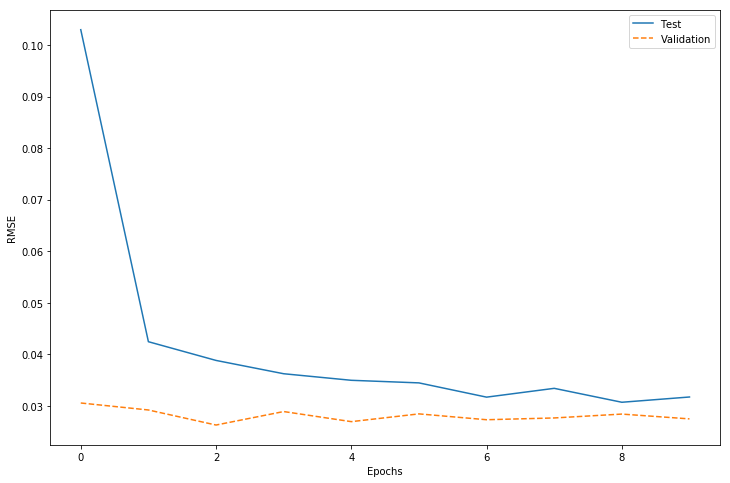

In [47]:
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(12,8))
plt.plot(hist.epoch,hist.history['loss'],    label='Test')
plt.plot(hist.epoch,hist.history['val_loss'],label='Validation',linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()